In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [3]:
wid = 80
oversample = 4

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)

flt = "F145M"

injected_params = {
    "fluxes": {f"injected_{flt}": np.asarray(5e8)},
    "positions": {f"injected_{flt}": np.asarray([-3e-7,1e-7])},
    "aberrations": {f"injected_{flt}":np.zeros(19).at[0].set(5e-9)},
    "cold_mask_shift": {f"injected_{flt}":np.asarray([-0.08, -0.08])},
    "cold_mask_rot": {f"injected_{flt}":np.asarray([np.pi/4])},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
}

injected_exposure = InjectedExposure("injected",flt,SinglePointFit())
exposures = [injected_exposure]

model = set_array(NICMOSModel(exposures, injected_params, optics, detector))
for e in exposures:
    e.inject(model, 5)

Array(4.78222167e+08, dtype=float64)

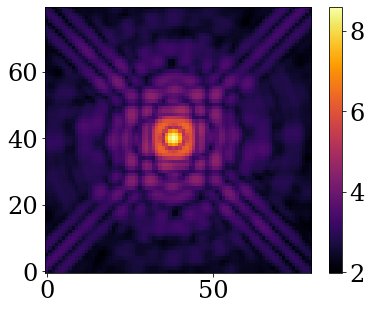

In [4]:
plt.imshow(exposures[0].data**0.125)
plt.colorbar()
np.sum(exposures[0].data)

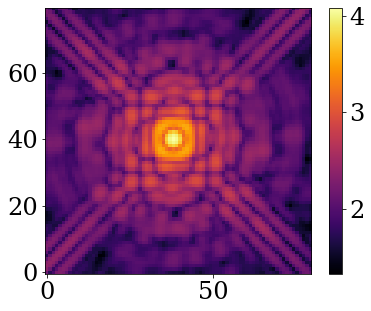

In [5]:
plt.imshow(np.log10(exposures[0].data/exposures[0].err))
plt.colorbar()

In [6]:
params = {
    "fluxes": {},
    "positions": {},
    "aberrations": {},#np.zeros(8),#np.asarray([0,18,19.4,-1.4,-3,3.3,1.7,-12.2])*1e-9,
    "cold_mask_shift": {}, #np.asarray([-0.05, -0.05]),
    "cold_mask_rot": {},#np.asarray([np.pi/4]),
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
}

for exp in exposures:
    params["positions"] = injected_params["positions"]#[exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["fluxes"] = injected_params["fluxes"]#[exp.fit.get_key(exp, "fluxes")] = np.nansum(exp.data)
    params["aberrations"] = injected_params["aberrations"]
    #params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(8)#jr.uniform(jr.key(0), (8,),minval=-4e-8, maxval=4e-8) #np.asarray([-8.59023084e-10,  1.77049982e-09, -4.45293089e-09, -3.70890613e-08,2.03658617e-08,  1.08092528e-08, -2.77077727e-09,  1.86458672e-09])*0.9#jr.uniform(jr.key(0), (8,),minval=-2e-8, maxval=2e-8)#np.zeros(8)#np.ones(8)*1e-8
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([-0.08,-0.08])
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = np.pi/4

params = ModelParams(params)
paths = ["cold_mask_shift.injected_F145M"]

In [7]:
print(params.params)

{'fluxes': {'injected_F145M': Array(5.e+08, dtype=float64, weak_type=True)}, 'positions': {'injected_F145M': Array([-3.e-07,  1.e-07], dtype=float64)}, 'aberrations': {'injected_F145M': Array([5.e-09, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00], dtype=float64)}, 'cold_mask_shift': {'injected_F145M': Array([-0.08, -0.08], dtype=float64)}, 'cold_mask_rot': {'injected_F145M': 0.7853981633974483}, 'outer_radius': 1.146, 'secondary_radius': 0.44639999999999996, 'spider_width': 0.0924}


In [8]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths)
def loss_fn(params,exposures):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [9]:
n = 32
losses = np.zeros((n,n))
cx = np.linspace(-0.16,0.16, n)#np.linspace(-10,10, n)*1e-9
cy = np.linspace(-0.16,0.16, n)
xgrad = np.zeros((n,n))
ygrad = np.zeros((n,n))

for i, x in enumerate(tqdm(cx)):
    for j, y in enumerate(tqdm(cy)):
        #params.params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([-0.08,y])
        params.params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([x,y])
        #params.params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(19).at[0].set(x)
        loss, grads = loss_fn(params, exposures)
        losses = losses.at[i,j].set(loss)
        #print(grads.get(paths[1]))
        xgrad = xgrad.at[i,j].set(grads.get(paths[0])[0])
        ygrad = ygrad.at[i,j].set(grads.get(paths[0])[1])

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

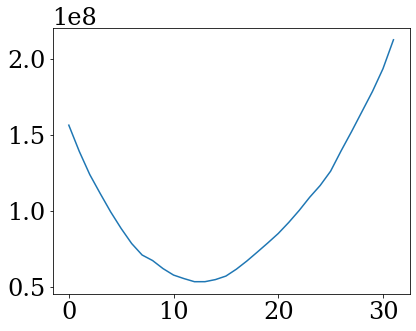

In [10]:
plt.plot(losses[:,0])

In [11]:
np.min(losses)

Array(218446.0594768, dtype=float64)

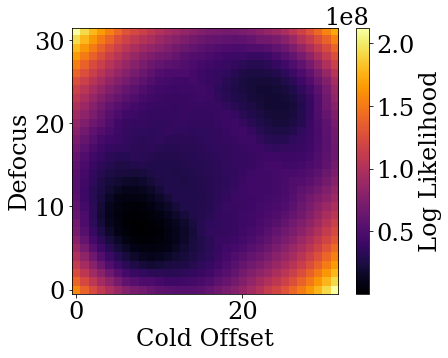

In [12]:
plt.imshow(losses)#, extent=[-0.16,0.16,-0.16,0.16])
plt.xlabel("Cold Offset")
plt.ylabel("Defocus")
plt.colorbar(label="Log Likelihood")

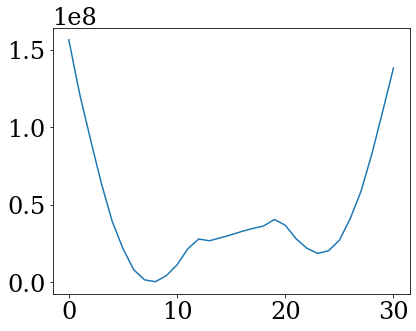

In [13]:
plt.plot(np.diag(losses)[:-1])

In [14]:
xgrad

Array([[-6.55199573e+08, -3.24915899e+09, -4.26247355e+08, ...,
         5.90686631e+08, -8.54751687e+08, -1.02017875e+09],
       [-3.71620458e+09, -3.62638888e+08, -5.94385961e+08, ...,
        -3.26449736e+08,  5.19248648e+08, -3.39402870e+09],
       [-4.42204076e+07, -7.20740829e+08, -5.83078277e+08, ...,
        -1.07624775e+09, -1.89423647e+09,  6.73058398e+08],
       ...,
       [-1.30371916e+09,  1.97857842e+09,  1.14835474e+09, ...,
         6.71757064e+08,  7.60197553e+08,  1.22713207e+08],
       [ 3.22716409e+09, -9.30721451e+08,  4.38267742e+08, ...,
         7.10986554e+08,  2.21039603e+08,  3.40308775e+09],
       [ 1.10207380e+09,  8.72557185e+08, -1.09033821e+09, ...,
         1.61068124e+08,  2.88290704e+09,  5.50302898e+08]],      dtype=float64)

Text(0.5, 0, 'Cold Mask Offset')

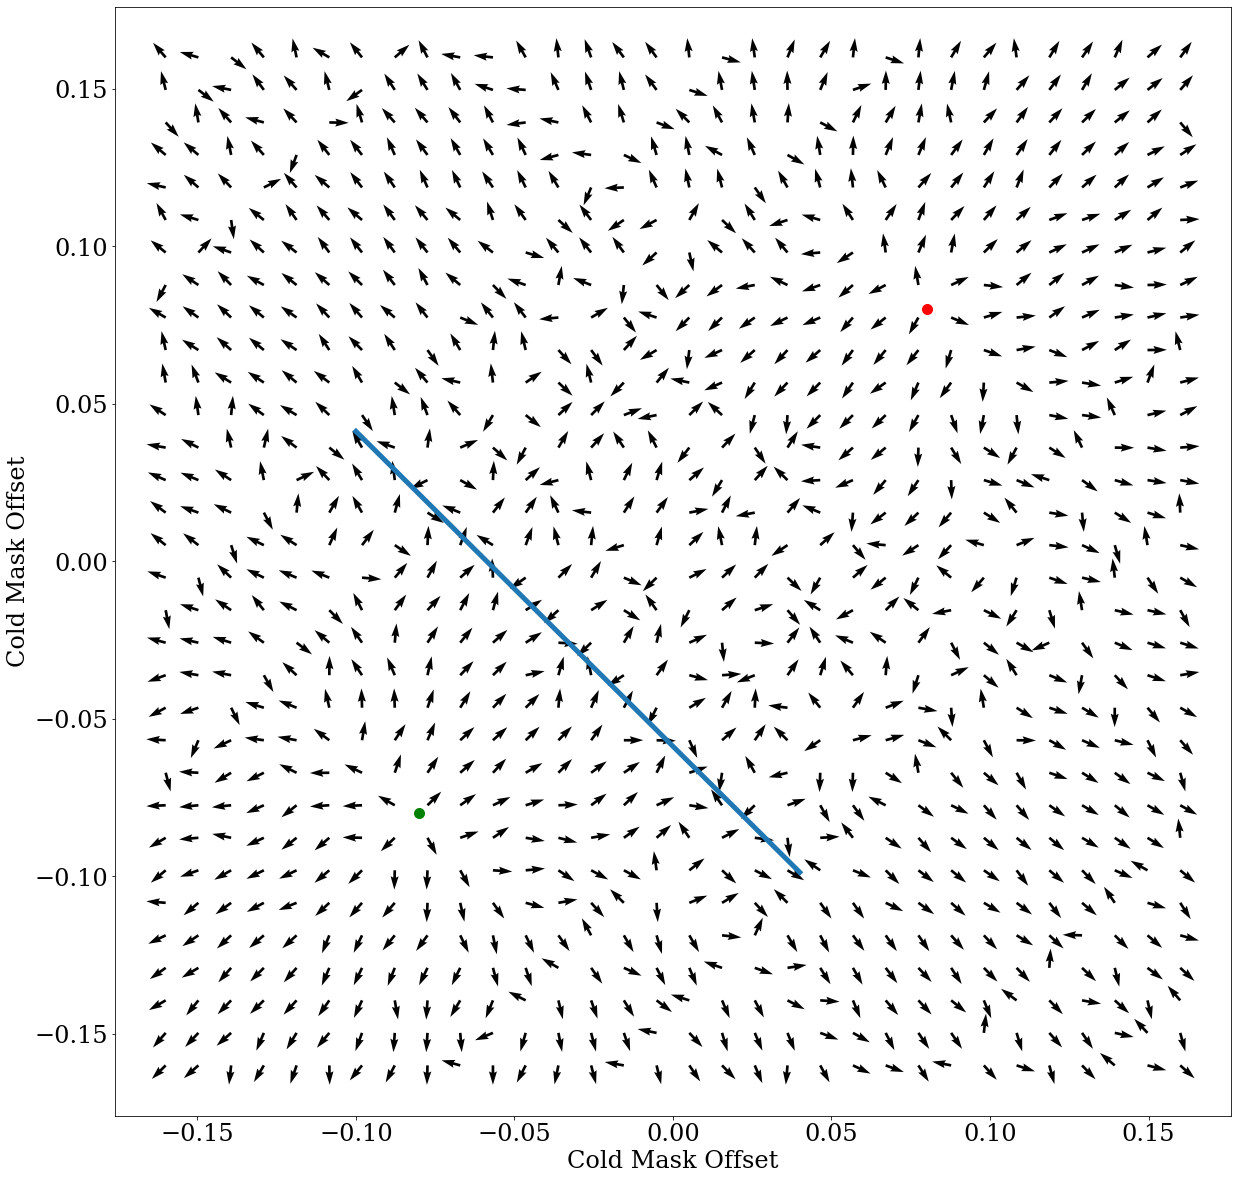

In [15]:
X = np.zeros((n,n))
Y = np.zeros((n,n))

for i, x in enumerate((cx)):
    for j, y in enumerate((cy)):
        X=X.at[i,j].set(x)
        Y=Y.at[i,j].set(y)


xt = np.linspace(-0.10, 0.04, 100)

plt.figure(figsize=(20,20))
norm = np.sqrt(xgrad**2 + ygrad**2)
plt.quiver(X,Y, xgrad/norm, ygrad/norm)
plt.plot(xt, -xt-5.87e-2, linewidth=5.0)
plt.plot(-0.08, -0.08, 'go', markersize=10)
plt.plot(0.08, 0.08, 'ro', markersize=10)

#plt.plot(xt, -xt+5.87e-2)

#plt.quiver(X,Y, xgrad, ygrad)
plt.ylabel("Cold Mask Offset")
plt.xlabel("Cold Mask Offset")

In [16]:
X

Array([[-0.16      , -0.16      , -0.16      , ..., -0.16      ,
        -0.16      , -0.16      ],
       [-0.14967742, -0.14967742, -0.14967742, ..., -0.14967742,
        -0.14967742, -0.14967742],
       [-0.13935484, -0.13935484, -0.13935484, ..., -0.13935484,
        -0.13935484, -0.13935484],
       ...,
       [ 0.13935484,  0.13935484,  0.13935484, ...,  0.13935484,
         0.13935484,  0.13935484],
       [ 0.14967742,  0.14967742,  0.14967742, ...,  0.14967742,
         0.14967742,  0.14967742],
       [ 0.16      ,  0.16      ,  0.16      , ...,  0.16      ,
         0.16      ,  0.16      ]], dtype=float64)

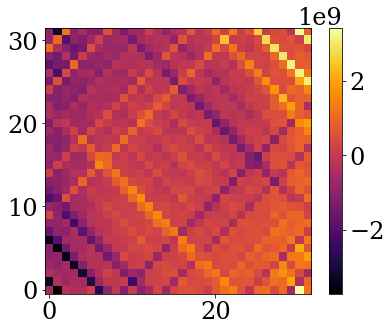

In [17]:
plt.imshow(ygrad)
plt.colorbar()

In [18]:
focus = np.linspace(-10,10, n)*1e-9
for j, y in enumerate(tqdm(focus)):
    params.params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([-0.08,-0.08])
    params.params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(19).at[0].set(y)
    loss, grads = loss_fn(params, exposures)
    losses = losses.at[i,j].set(loss)
    #print(grads.get(paths[1]))
    xgrad = xgrad.at[i,j].set(grads.get(paths[1])[0])
    ygrad = ygrad.at[i,j].set(grads.get(paths[0])[1])

  0%|          | 0/32 [00:00<?, ?it/s]

IndexError: list index out of range